In [61]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from scipy.stats import norm
import csv
import yaml
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.modeling import models, fitting
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
from astroquery.esasky import ESASky
from astropy.nddata import Cutout2D
from astropy import wcs
import pickle as pk


%matplotlib inline

In [71]:
def central_emission(hmap, map_w, pixel_w, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    center = map_w + 0.5
    
    emission = 0
    div = 0
    
    for i in range(2*map_w):
        for j in range(2*map_w):
            if pixel_w*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                emission += hmap[i,j]
                div +=1
    return emission, div

In [63]:
def hersch_stacker(hmap, freq, ras, decs, width):
    stack = 0
    divisor = 0
    width = int(width)
    freq = freq
    hmap = hmap
    
    print(freq,hmap)

    hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/HATLAS_{}_BACKSUB{}.FITS'.format(hmap,freq))
    w = wcs.WCS(hi_data[0].header)
    for i in range(len(ras)):
        px, py = w.wcs_world2pix(ras[i], decs[i], 1)
        if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
            continue
        px = np.round(px).astype(int)
        py = np.round(py).astype(int)
        try:
            cutout = Cutout2D(hi_data[0].data, (px,py), width *2, mode = 'strict')
        except:
            continue
        stamp = cutout.data

        if not np.any(stamp):
            continue
    
        if stamp.shape != (2*width, 2*width):
            continue

        stack += stamp
        divisor += 1

    if divisor == 0:
        return
    stack /= divisor

    fig = plt.figure()

    bound = width*0.001667*60

    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()
    plt.title('MaDCoWS Clusters in {} {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    plt.savefig('./plots/herschel/{}_{}_mdcw.pdf'.format(hmap, freq))
    plt.savefig('./plots/herschel/{}_{}_mdcw.png'.format(hmap, freq), dpi = 300)
    plt.show()
    plt.close()

In [64]:
def filt_hersch_stacker(hmap, freq, ras, decs, width):
    stack = 0
    divisor = 0
    width = int(width)
    freq = freq
    hmap = hmap
    
    print(freq,hmap)

    hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/filtered/HATLAS_{}_FILT_BACKSUB{}.FITS'.format(hmap,freq))
    w = wcs.WCS(hi_data[0].header)
    for i in range(len(ras)):
        px, py = w.wcs_world2pix(ras[i], decs[i], 1)
        if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
            continue
        px = np.round(px).astype(int)
        py = np.round(py).astype(int)
        try:
            cutout = Cutout2D(hi_data[0].data, (px,py), width *2, mode = 'strict')
        except:
            continue
        stamp = cutout.data

        if not np.any(stamp):
            continue
    
        if stamp.shape != (2*width, 2*width):
            continue
        
        stack += stamp
        divisor += 1

    if divisor == 0:
        return
    stack /= divisor

    fig = plt.figure()

    bound = width*0.001667*60

    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()
    plt.title('MaDCoWS Clusters in {} Filtered {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    plt.scatter(0,0, marker = '+', color = 'r')
    plt.savefig('./plots/herschel/filt_{}_{}_mdcw.pdf'.format(hmap, freq))
    plt.savefig('./plots/herschel/filt_{}_{}_mdcw.png'.format(hmap, freq), dpi = 300)
    plt.show()
    plt.close()
    
    cent_scale = 4
    
    center_mean = np.mean(stack[width - cent_scale:width + cent_scale -1,width - cent_scale:width + cent_scale -1])
                            
    print('{} Filtered {} $\mu$m has mean {}'.format(hmap, freq, center_mean))

In [65]:
def filt_full_hersch_stacker(freq, ras, decs, name,  weight = True, width = 50., zs = None):
    stack = 0
    z = 0
    zdiv = 0
    divisor = 0
    width = int(width)
    freq = freq
    name = str(name)
    
    #print(freq)
    
    hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']

    for hmap in hmaps:
        #Gama12 250 header currently bugged, temporarily just skip
        if freq == '250' and hmap == 'GAMA12_DR1':
            continue

        #print('Loading map {} {}'.format(hmap, freq), end = '\r')
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_0.9SMOOTH.fits'.format(hmap,freq))
        
        w = wcs.WCS(hi_data[0].header)
        #print('Map {} {} loaded'.format(hmap, freq), end = '\r')
        
        hdata = hi_data[0].data
        
        for i in range(len(ras)):
            print(round(i/len(ras),2), end =  '\r')
            px, py = w.wcs_world2pix(ras[i], decs[i], 1)
            if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
                continue
            px = np.round(px).astype(int)
            py = np.round(py).astype(int)
            try:
                cutout = Cutout2D(hdata, (px,py), width *2, mode = 'strict')
            except:
                continue
            stamp = cutout.data

            if not np.any(stamp):
                continue
            if stamp[width, width] ==0:
                continue
            if stamp.shape != (2*width, 2*width):
                continue
            
            if weight:
            
                weight_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/filtered/HATLAS_{}_FILT_SIGMA{}.FITS'.format(hmap,freq))
                weight_w = wcs.WCS(weight_data[0].header)

                weight_px, weight_py = weight_w.wcs_world2pix(ras[i], decs[i], 1)
                weight_px = np.round(weight_px).astype(int)
                weight_py = np.round(weight_py).astype(int)

                weight_val = weight_data[0].data[weight_px,weight_py]

                if weight_val <= 10**-20:
                    continue
            else:
                weight_val = 1

            if zs is not None:
                if zs[i] < 100 and not np.isnan(zs[i]):
                    z += zs[i]
                    zdiv += 1
            
            stack += stamp/weight_val
            divisor += 1/weight_val


    if divisor == 0:
        return
    stack /= divisor
    z/= zdiv
        
    #Calculate mean surface brighness within 0.9' and convert from MJy/beam to MJy/sr

    
    pixel_size = (hi_data[0].header['CDELT2']*3600*u.arcsec)**2
    
    #total, div = central_emission(stack, width, wcs.utils.proj_plane_pixel_scales(w)[0]*60, 0.45)
    #center_mean_Jy = total*u.Jy/(div*pixel_size)
    center_mean_Jy = central_emission(stack, width, wcs.utils.proj_plane_pixel_scales(w)[0]*60, 0.45)[0]*u.Jy/(np.pi*(0.9*u.arcmin)**2)
    print(center_mean_Jy)
    center_mean = (center_mean_Jy).to(u.MJy/u.sr) 
    
    #Calculate variance same way as above using strip away from center to estimate map variance
    map_var_Jy = np.std(stack[60:99, 0:99]/pixel_size.value)*u.Jy/pixel_size.unit
    map_var = (map_var_Jy).to(u.MJy/u.sr) 
    
    #Plot the stack
    fig, axes = plt.subplots()

    bound = width*wcs.utils.proj_plane_pixel_scales(w)[0]*60
   
    plt.imshow(stack, origin='lower', cmap=plt.cm.viridis, extent = [-bound,bound, -bound,bound])
    plt.colorbar()

    plt.title('{} Clusters at {} $\mu$m, {} in Stack  with z = {:0.3}\n {:0.2e} $\pm$ {:0.2e} MJy/sr central emission'.format(name, 
                                            freq, divisor, z, center_mean.value, map_var.value))
    plt.xlabel('RA (arcmin)')
    plt.ylabel('Dec (arcmin)')
    #plt.scatter(0,0, marker = '+', color = 'r')
    draw_circle = plt.Circle((0, 0), 0.45, color = 'r',fill=False, alpha = 0.5)
    axes.set_aspect(1)
    axes.add_artist(draw_circle)

    plt.savefig('./plots/herschel/smooth_0.9_full_filt_{}_{}.pdf'.format(freq, name))
    plt.savefig('./plots/herschel/smooth_0.9_full_filt_{}_{}.png'.format(freq, name), dpi = 300)

    plt.show()
    plt.close()
    

                            
    #print('Filtered {} $\mu$m has mean {}'.format(freq, center_mean))
    return stack, center_mean, map_var

In [66]:
def hersch_stamper(freq, ras, decs, width, names):

    stack = 0
    z = 0
    zdiv = 0
    divisor = 0
    width = int(width)
    freq = freq
    stamps = {}

    #print(freq)
    
    hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']

    for hmap in hmaps:
        #Gama12 250 header currently bugged, temporarily just skip
        if freq == '250' and hmap == 'GAMA12_DR1':
            continue

        #print('Loading map {} {}'.format(hmap, freq), end = '\r')
        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_0.9SMOOTH.fits'.format(hmap,freq))
        
        w = wcs.WCS(hi_data[0].header)
        #print('Map {} {} loaded'.format(hmap, freq), end = '\r')
        
        hdata = hi_data[0].data
        
        for i in range(len(ras)):
            print(round(i/len(ras),2), end =  '\r')
            px, py = w.wcs_world2pix(ras[i], decs[i], 1)
            if np.isnan(px) or np.isnan(py) or ((px+width) >hi_data[0].data.shape[0]) or ((py+width) > hi_data[0].data.shape[0]):
                continue
            px = np.round(px).astype(int)
            py = np.round(py).astype(int)
            try:
                cutout = Cutout2D(hdata, (px,py), width *2, mode = 'strict')
            except:
                continue
            stamp = cutout.data

            if not np.any(stamp):
                continue
            if stamp[width, width] ==0:
                continue
            if stamp.shape != (2*width, 2*width):
                continue
            stamps[names[i]] = [stamp, wcs.utils.proj_plane_pixel_scales(w)[0]]

            """
            fig = plt.figure()

            bound = width*wcs.utils.proj_plane_pixel_scales(w)[0]*60

            center_mean = np.mean(stamp[width - cent_scale:width + cent_scale -1,width - cent_scale:width + cent_scale -1])*10**3

            plt.imshow(stamp, origin='lower', cmap=plt.cm.viridis, vmin = -20*10**-3, vmax = 20*10**-3, extent = [-bound,bound, -bound,bound])
            plt.colorbar()
            plt.title('{} in {} Filtered {} $\mu$m \n {:0.3e} mJy/sr central emission'.format(names[i], hmap, freq, center_mean))
            plt.xlabel('RA (arcmin)')
            plt.ylabel('Dec (arcmin)')
            plt.scatter(0,0, marker = '+', color = 'r')

            plt.savefig('./plots/herschel/indv_clusters/filt_{}_{}.pdf'.format(freq, names[i].replace(' ', '_')))
            plt.savefig('./plots/herschel/indv_clusters/filt_{}_{}.png'.format(freq, names[i].replace(' ', '_')), dpi = 300)
            plt.show()
            plt.close()
            """
    return stamps

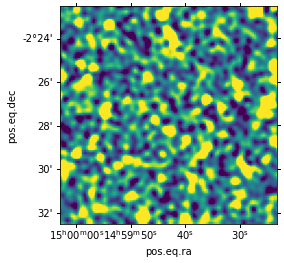

In [23]:
hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_{}_FILT_BACKSUB{}_0.9FILT.fits'.format('GAMA15_DR1',250))
w = wcs.WCS(hi_data[0].header)

bound = 1e-2
fig = plt.figure()

fig.add_subplot(111, projection=w)

plt.imshow(hi_data[0].data[1000:1100, 1000:1100], vmin = -bound, vmax = bound)
plt.show()

250 GAMA12_DR1


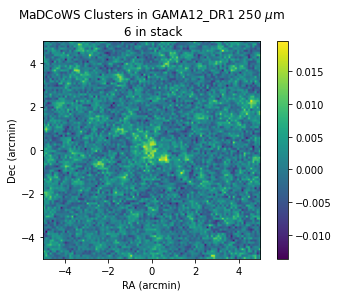

350 GAMA12_DR1


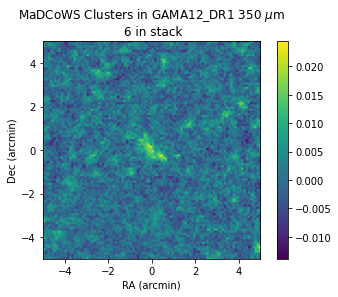

500 GAMA12_DR1


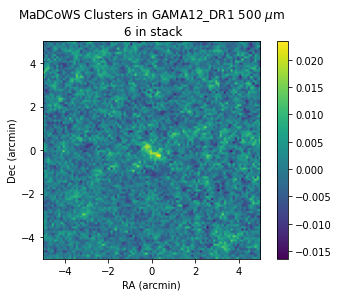

250 GAMA15_DR1


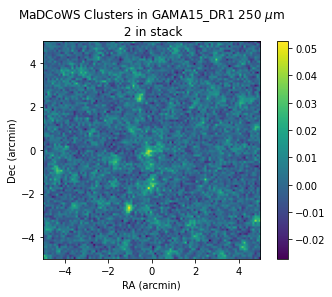

350 GAMA15_DR1


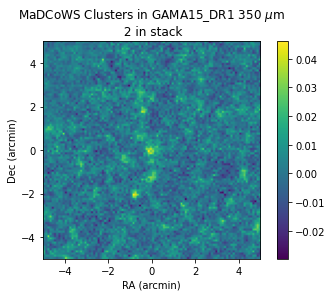

500 GAMA15_DR1


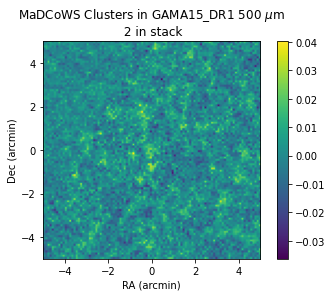

250 GAMA9_DR1


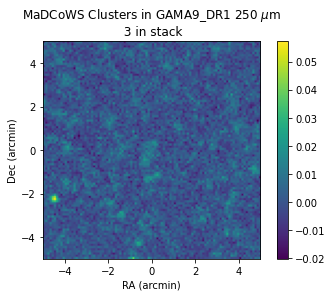

350 GAMA9_DR1


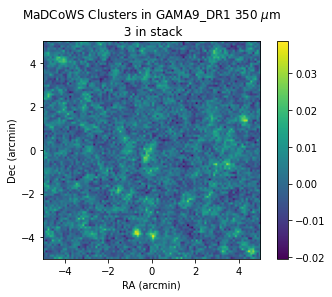

500 GAMA9_DR1


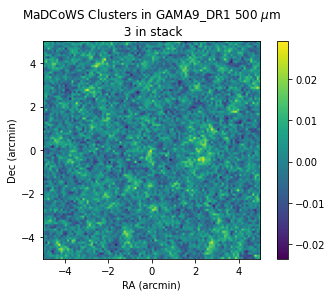

250 NGP_DR2


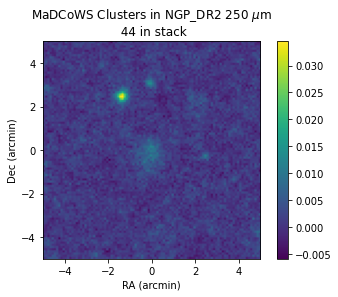

350 NGP_DR2


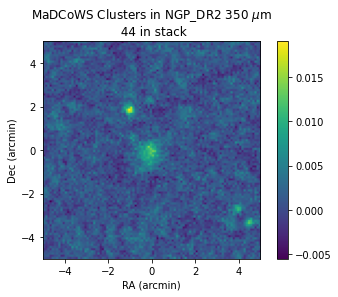

500 NGP_DR2


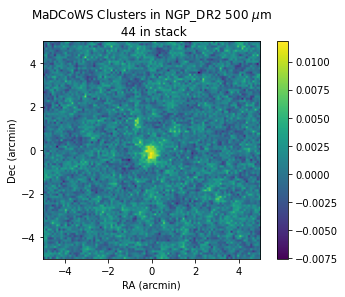

250 SGP_DR2


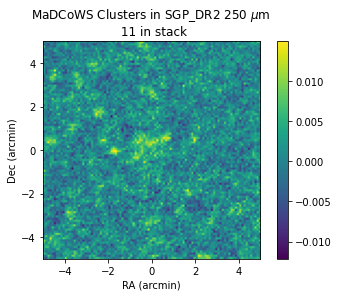

350 SGP_DR2


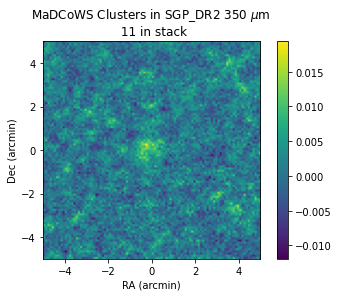

500 SGP_DR2


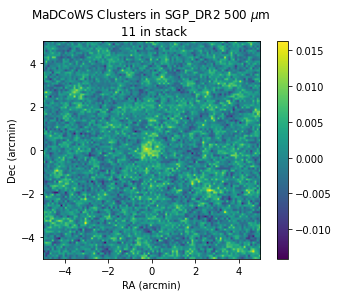

In [23]:
hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']
freqs = ['250', '350', '500']

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ras = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
decs = mdcw_catalog[1].data['decDeg']
ras, decs = np.array(ras), np.array(decs)

for hmap in hmaps:
    for freq in freqs:
        hersch_stacker(hmap, freq, ras, decs, 50.)

In [12]:
hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_NGP_DR2_FILT_BACKSUB500_0.9FILT.fits')
w = wcs.WCS(hi_data[0].header)
print(hi_data[0].header)
hi_data[0].header['CDELT2']*3600*3

SIMPLE  =                    T / Written by IDL:  Wed Dec  6 18:28:29 2017      BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                 4784                                                  NAXIS2  =                 4351                                                  CTYPE1  = 'RA---TAN'                                                            CTYPE2  = 'DEC--TAN'                                                            CRVAL1  = 197.9929459955868083                                                  CDELT1  =   -0.003333333333333                                                  CRPIX1  =                 2788                                                  CRVAL2  =  26.0900597940217409                                                  CDELT2  =    0.003333333333333                                                  CRPIX2  =                 1235          

35.999999999996405

In [10]:
herschel_ps =  fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/HATLAS_NGP_DR2_CATALOGUE_V1.4.FITS')

ras = herschel_ps[1].data['RA']
decs = herschel_ps[1].data['DEC']
ras, decs = np.array(ras), np.array(decs)


250 NGP_DR2


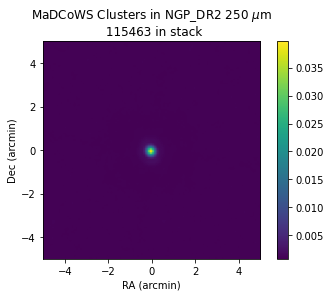

350 NGP_DR2


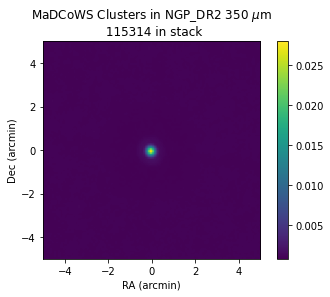

500 NGP_DR2


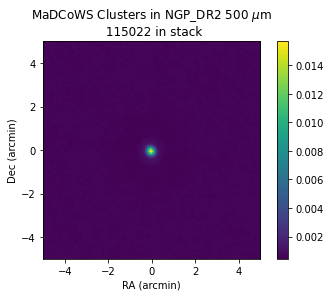

In [11]:

freqs = [ '250', '350', '500']
for freq in freqs:
    hersch_stacker('NGP_DR2', freq, ras, decs, 50.)

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


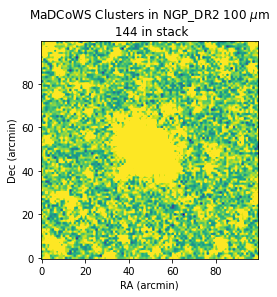

In [153]:
px2, py2 = w.wcs_world2pix(ras[1], decs[1], 1)


px2 = np.round(px2).astype(int)
py2 = np.round(py2).astype(int)

#stamp = hi_data[0].data[px-50: px+50, py-50: py+50]

cutout2 = Cutout2D(hi_data[0].data, (px2,py2), 100)

fig.add_subplot(111, projection=w)
plt.imshow(cutout2.data, origin='lower', cmap=plt.cm.viridis, vmax = 1e-2)
plt.title('MaDCoWS Clusters in {} {} $\mu$m \n {} in stack'.format(hmap, freq, divisor))
plt.xlabel('RA (arcmin)')
plt.ylabel('Dec (arcmin)')
#plt.savefig('./plots/herschel/{}_{}_filtered_mdcw.pdf'.format(hmap, freq))
#plt.savefig('./plots/herschel/{}_{}_filtered_mdcw.png'.format(hmap, freq), dpi = 300)
plt.show()
plt.close()

In [157]:
stack = cutout.data + cutout2.data
stack  /= 2

In [7]:
hmaps = ['GAMA12_DR1','GAMA15_DR1', 'GAMA9_DR1', 'NGP_DR2', 'SGP_DR2']
freqs = ['250', '350', '500']

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ras = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
decs = mdcw_catalog[1].data['decDeg']
zs = mdcw_catalog[1].data['Photz']
ras, decs = np.array(ras), np.array(decs)

0.005621829099369582 Jy / arcmin2


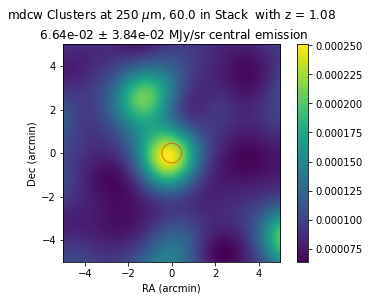

0.0038749450246822535 Jy / arcmin2


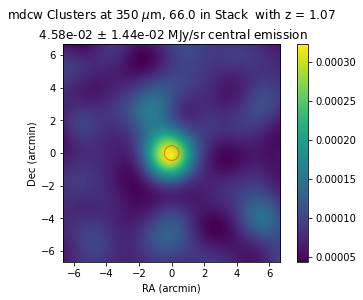

0.0019242619498875575 Jy / arcmin2


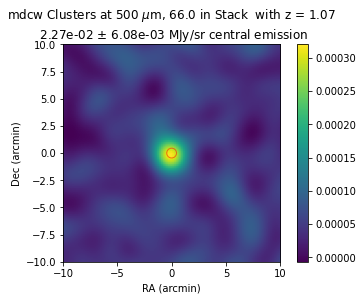

In [67]:
smooth_stacks = {'250':[], '350':[], '500':[]}
mdcw_stamps = {}

for freq in freqs:
        
    stack, cent, cent_var = filt_full_hersch_stacker(freq, ras, decs, 'mdcw', width = 50., zs = zs, weight = False)
    smooth_stacks[freq].append(stack)
    
    stamp = hersch_stamper(freq,ras, decs, 50.,names)
    mdcw_stamps[freq] = stamp
    
        
pk.dump(mdcw_stamps, open('mdcw_stamps.pk', 'wb'))

In [36]:
stamps = mdcw_stamps['250']

good_names = []
sigmas = []

beam = 1.8

for key in stamps.keys():
    stamp = stamps[key][0]
    pixel_size = stamps[key][1]*60*u.arcmin
    plt.imshow(stamp)
    #plt.show()
    plt.close()
    
    em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
    em = em*u.Jy
    em = em.to(u.MJy)

    pixel_area = (pixel_size)**2
    pixel_area = pixel_area.to(u.sr)
    
    mean_cent_em = em/(num*pixel_area)
    map_var_Jy = np.std(stamp[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
    map_var = (map_var_Jy).to(u.MJy/u.sr) 

    
    if mean_cent_em/map_var > 4:
        print(mean_cent_em/map_var)
        good_names.append(key)  
        sigmas.append(mean_cent_em/map_var)

6.822338260270193
4.139220595984491
4.275358602581502
5.246238966787256
4.206067043194683
5.783538306671279
9.245464603846502
4.128450171326372
4.268824734974363
4.543532793072858
15.256258551057055
5.72746946400925


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale         
            K                 MJy / sr       
    ------------------ ----------------------
    49.298118717139296 4.5310014758737156e-07


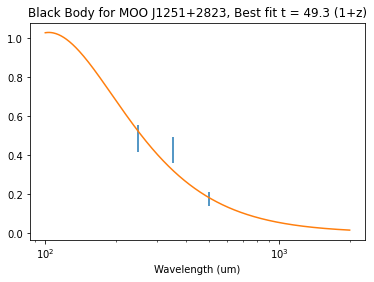

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0                alpha       
         MJy / sr             GHz                            
    ------------------ ------------------ -------------------
    0.5026674264438291 1158.0751767060992 -1.5556771572159873


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


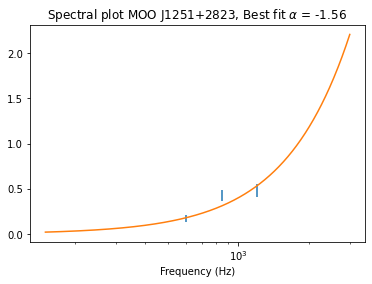

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale         
            K                 MJy / sr       
    ------------------ ----------------------
    5190.6754436350875 1.8385349924932512e-09


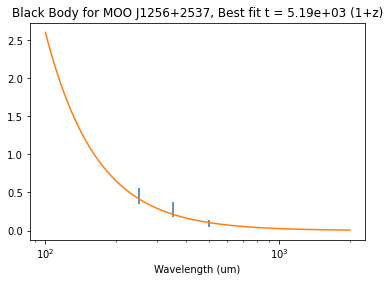

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0               alpha       
         MJy / sr            GHz                           
    ------------------ ---------------- -------------------
    0.1616687154337529 747.851576107445 -2.2787517826282047


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


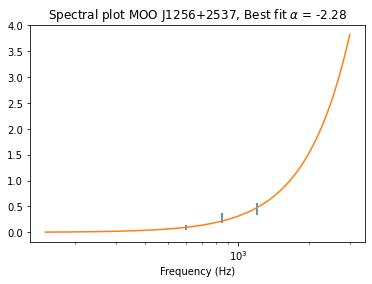

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ----------------- ---------------------
    1267.651590058619 5.839444102004889e-09


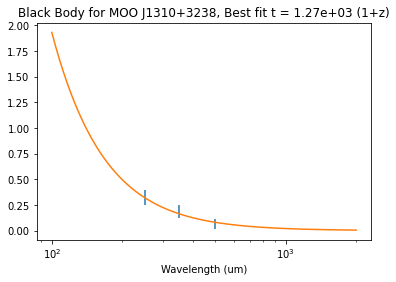

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             x_0              alpha       
          MJy / sr             GHz                          
    ------------------- ----------------- ------------------
    0.11588272121544616 735.2926589077294 -2.184532091923278


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


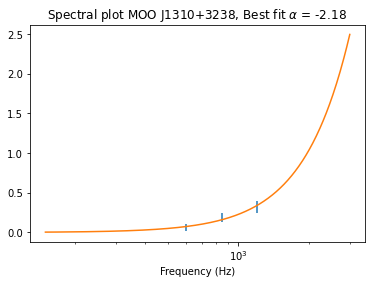

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature           scale        
            K               MJy / sr      
    ----------------- --------------------
    1896.516713935007 8.31729838349763e-09


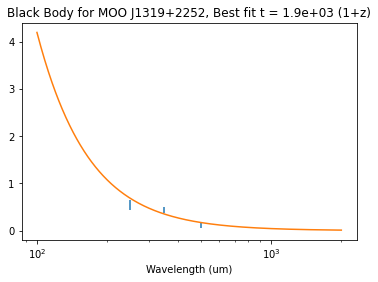

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0                alpha       
         MJy / sr            GHz                            
    ----------------- ------------------ -------------------
    2.163055449687027 1937.3245781357582 -2.2240267744839763


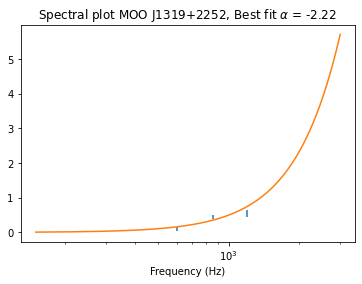

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      temperature            scale         
           K                MJy / sr       
    ---------------- ----------------------
    3997.79124290642 2.2727130453256866e-09


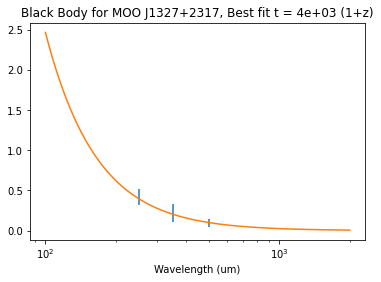

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             x_0              alpha       
          MJy / sr             GHz                          
    ------------------- ----------------- ------------------
    0.11234344066203689 648.0848823673889 -2.129233244349692


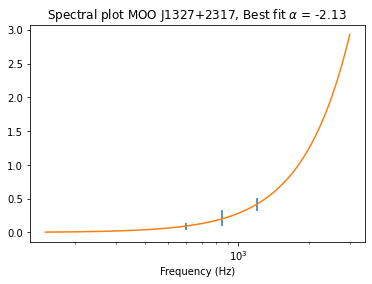

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ------------------ --------------------
    135.00719574928297 1.05981705754292e-07


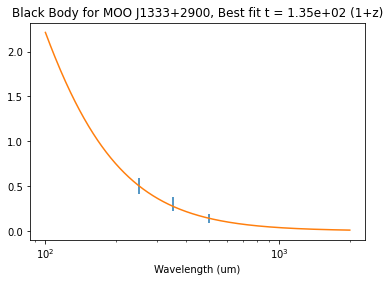

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             x_0               alpha       
          MJy / sr             GHz                           
    ------------------- ----------------- -------------------
    0.19146268252908985 706.1402317318408 -1.8472467333096534


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


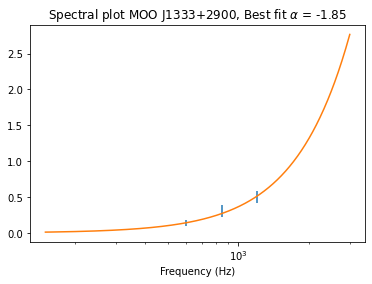

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale         
            K                 MJy / sr       
    ------------------ ----------------------
    27.390999185758208 1.1077496323595374e-06


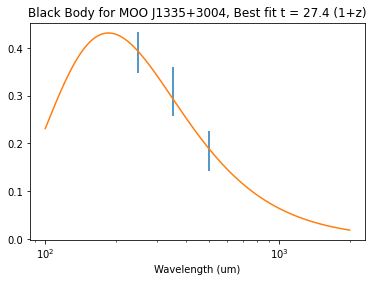

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0               alpha       
         MJy / sr            GHz                           
    ----------------- ----------------- -------------------
    0.887332134822078 2614.086417108773 -1.0366067622731319


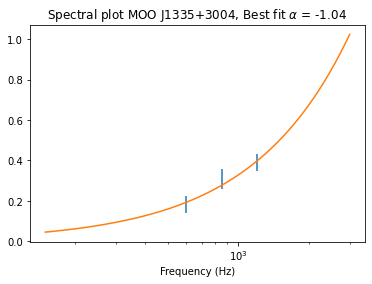

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    552.4115595446974 1.0505744861118643e-08


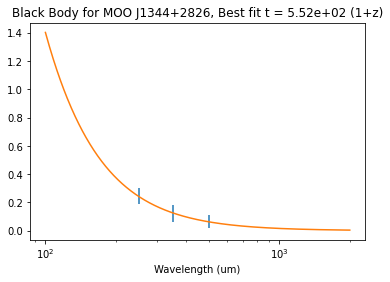

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0               alpha       
         MJy / sr            GHz                           
    ----------------- ----------------- -------------------
    0.380534999760294 1509.007936478327 -1.9513688446691007


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


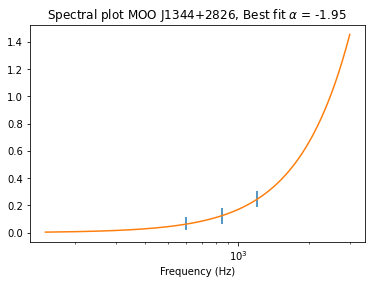

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    51.75037406064835 1.5511266430937266e-07


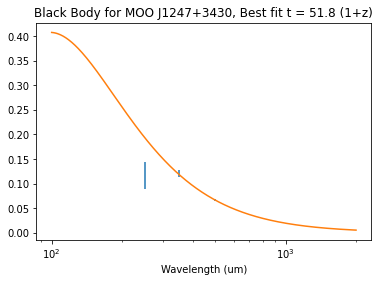

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude               x_0                 alpha       
         MJy / sr               GHz                             
    ------------------ --------------------- -------------------
    0.8793588556507845 7.863965439272593e-06 0.14208494548148193


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


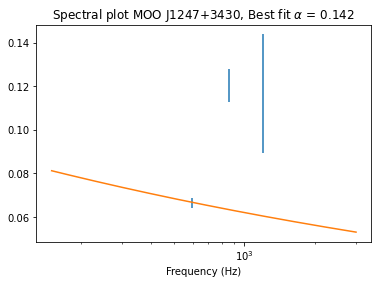

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    45.61250570260104 4.0469341839554984e-07


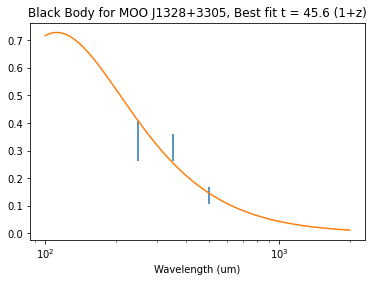

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            x_0                alpha       
         MJy / sr            GHz                            
    ----------------- ------------------ -------------------
    1.122382748137434 2242.6765749514298 -1.5500348556233823


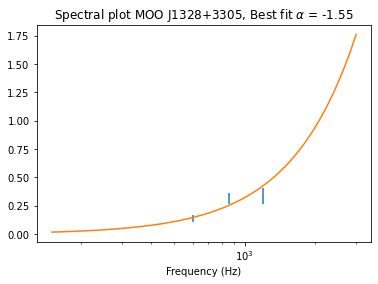

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale         
            K                 MJy / sr       
    ------------------ ----------------------
    187.74701766546957 3.3807006037374625e-09


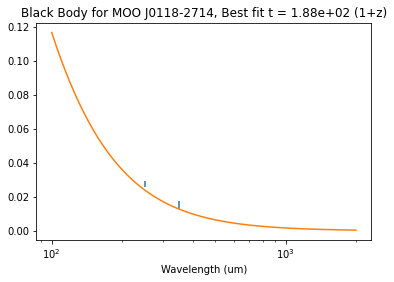

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              x_0                 alpha       
         MJy / sr              GHz                             
    ------------------ -------------------- -------------------
    0.8053351456502404 0.024164014607905807 0.47644180818685117


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


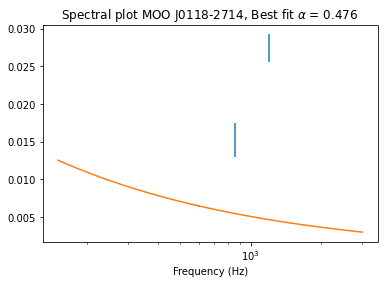

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ----------------- ---------------------
    55.69010939439036 3.268463390424003e-07


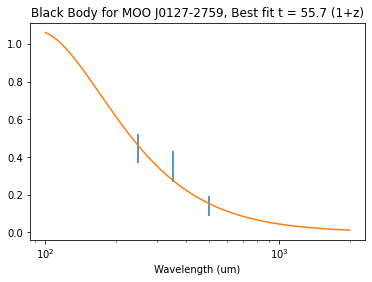

[1199.169832  856.54988   599.584916] GHz
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude             x_0              alpha       
          MJy / sr             GHz                          
    ------------------- ----------------- ------------------
    0.29098580545775715 897.4421430047059 -1.607792042010285


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:50: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


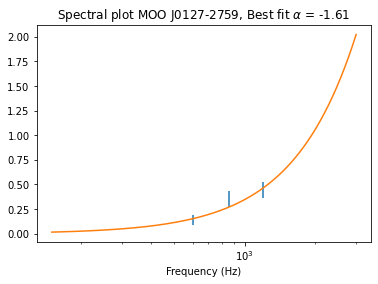

In [60]:
ts = []
indecies = []
t_errs = []

for name in good_names:
    MJys = []
    MJys_err = []
    fit_freqs = np.array([250, 350, 500])*u.um
    
    for freq in ['250', '350', '500']:
        stamps = mdcw_stamps[freq]
        stamp, pixel_size = stamps[name][0], stamps[name][1]*60*u.arcmin
        
        em, num = central_emission(stamp, 50, pixel_size.value, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)

        pixel_area = (pixel_size)**2
        pixel_area = pixel_area.to(u.sr)

        mean_cent_em = em/(num*pixel_area)
        map_var_Jy = np.std(stamp[60:99, 0:99]/pixel_area.value)*u.Jy/pixel_area.unit
        map_var = (map_var_Jy).to(u.MJy/u.sr) 
        
        MJys_err.append(map_var.value)
        MJys.append(mean_cent_em.value)
        
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-8 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()
    MJys_err = np.array(MJys_err)*u.MJy/u.sr

    
    best_fit = fitter(model, fit_freqs, MJys, weights=1.0/MJys_err**2)
    scales.append(best_fit.scale.value)
    print(best_fit)
    try:
        cov_diag = np.diag(fitter.fit_info['param_cov'])
    except:
        cov_diag = [0*u.K]
    
    
    

    wav = np.arange(100, 2000) * u.um
    flux = best_fit(wav).to(u.MJy/u.sr)


    plt.figure()
    plt.title('Black Body for {}, Best fit t = {:0.3} (1+z)'.format(name, best_fit.temperature.value))
    plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Wavelength (um)')
    
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close
    
    ts.append(best_fit.temperature.value)
    t_errs.append(cov_diag[0].value)
    
    #Fit for spectral index
    power_law = models.PowerLaw1D(x_0 = 2000)
    fit = fitting.LevMarLSQFitter()
    print(fit_freqs.to(u.GHz, equivalencies=u.spectral()))
    fitted_power = fit(power_law,fit_freqs.to(u.GHz, equivalencies=u.spectral()), MJys, weights=1.0/MJys_err**2)
                      
    print(fitted_power)
    
    
    wav = np.arange(100, 2000) * u.um
    wav = wav.to(u.GHz, equivalencies=u.spectral())
    flux = fitted_power(wav)


    plt.figure()
    plt.title(r'Spectral plot {}, Best fit $\alpha$ = {:0.3} '.format(name, fitted_power.alpha.value))
    plt.errorbar(fit_freqs.to(u.GHz, equivalencies=u.spectral()).value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    
    plt.xlabel('Frequency (Hz)')
    
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')

    
    plt.savefig('./plots/herschel/indv_clusters/spectral_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/spectral_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close

In [316]:
print(good_names,sigmas, ts)

['MOO J1454+0032', 'MOO J1251+2823', 'MOO J1254+3320', 'MOO J1256+2537', 'MOO J1310+3238', 'MOO J1319+2252', 'MOO J1321+2711', 'MOO J1322+3134', 'MOO J1327+2317', 'MOO J1333+2900', 'MOO J1335+3004', 'MOO J1337+3529', 'MOO J1340+3011', 'MOO J1344+2826', 'MOO J1247+3430', 'MOO J1328+3305', 'MOO J0118-2714', 'MOO J0127-2759', 'MOO J0139-3120'] [<Quantity 4.3201912>, <Quantity 8.07561799>, <Quantity 4.19252924>, <Quantity 4.87153639>, <Quantity 4.69597901>, <Quantity 5.66604954>, <Quantity 4.51179547>, <Quantity 4.35347974>, <Quantity 4.83826277>, <Quantity 6.80957386>, <Quantity 10.80070189>, <Quantity 4.24018245>, <Quantity 4.27802407>, <Quantity 4.90470917>, <Quantity 4.83422833>, <Quantity 5.2481736>, <Quantity 11.71072614>, <Quantity 6.52618126>, <Quantity 4.49094005>] [3093.6902458619393, 49.902465981369524, 19.34349390635666, 6347.211594942679, 2930.2377386072912, 1775.021769938699, 31.85719200991918, 44.71506294213962, 2291.8103339814343, 212.76545699517987, 29.035611026760066, 69.

[0.00701    0.23656521 0.16732553 0.07550188] MJy / sr


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature             scale        
            K                 MJy / sr      
    ------------------ ---------------------
    1421.3583689185464 3.382746504961679e-09


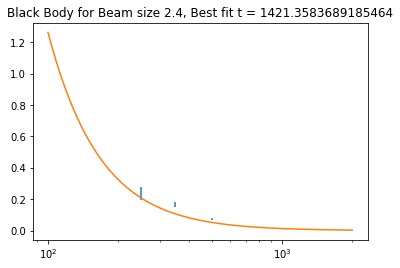

In [70]:
#beams = np.linspace(0.4, 1.5, 10)

beams = [2.4]

infered_t = []
infered_t_err = []

scales = []

for beam in beams:
    MJys = [0.00701]
    MJys_err = np.array([0.000967, 0.0384, 0.0144, 0.00608])*u.MJy/u.sr
    fit_freqs = np.array([1362.69, 250, 350, 500])*u.um
    
    for freq in freqs:

        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_SGP_DR2_FILT_BACKSUB{}_0.9SMOOTH.fits'.format(freq))


        w = wcs.WCS(hi_data[0].header)
        pixel_size = (wcs.utils.proj_plane_pixel_scales(w)[0]*60*u.arcmin)**2
        pixel_size = pixel_size.to(u.sr)
        em, num = central_emission(smooth_stacks[freq][0], 50, wcs.utils.proj_plane_pixel_scales(w)[0]*60, beam/2)
        em = em*u.Jy
        em = em.to(u.MJy)
        
        area = (np.pi*(beam/2*u.arcmin)**2).to(u.sr)

        #MJys.append((em/area).value)
        MJys.append((em/(num*pixel_size)).value)
        #print('Emission at {}: {}'.format(freq,em/area))
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-8 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()
    print(MJys)
    
    cut = 0
    
    best_fit = fitter(model, fit_freqs[cut:], MJys[cut:], weights=1.0/MJys_err[cut:]**2)
    scales.append(best_fit.scale.value)
    infered_t.append(best_fit.temperature.value)
    print(best_fit)
    #cov_diag = np.diag(fitter.fit_info['param_cov'])
    #infered_t_err.append(np.sqrt(cov_diag)[0].value)
    
    

    wav = np.arange(100, 2000) * u.um
    flux = best_fit(wav).to(u.MJy/u.sr)


    plt.figure()
    plt.title('Black Body for Beam size {}, Best fit t = {}'.format(beam, best_fit.temperature.value))
    plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
    plt.semilogx(wav, flux)
    #plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.pdf'.format(name))
    plt.savefig('./plots/herschel/indv_clusters/blackbody_{}.png'.format(name), dpi = 300)
    
    plt.show()
    plt.close


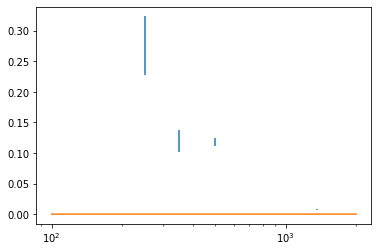

In [235]:
bb = models.BlackBody(temperature=infered_t*u.K, scale = scales)

wav = np.arange(100, 2000) * u.um
flux = bb(wav).to(u.MJy/u.sr)


plt.figure()
plt.errorbar(fit_freqs.value, MJys.value, yerr = MJys_err.value, linestyle = 'none')
plt.semilogx(wav, flux)
#plt.axvline(bb.nu_max.to(u.um, equivalencies=u.spectral()).value, ls='--')
plt.show()

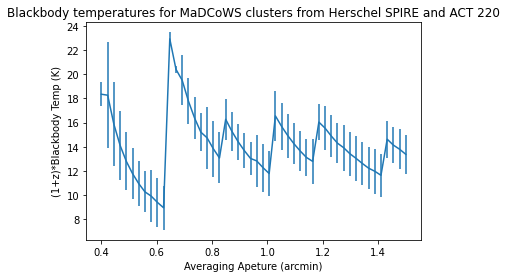

In [145]:

plt.errorbar(beams, infered_t, yerr = infered_t_err)
plt.xlabel('Averaging Apeture (arcmin)')
plt.ylabel('(1+z)*Blackbody Temp (K)')
plt.title('Blackbody temperatures for MaDCoWS clusters from Herschel SPIRE and ACT 220')
plt.savefig('./plots/herschel/blackbody.pdf')
plt.savefig('./plots/herschel/blackbody.png', dpi = 300)
plt.show()

In [139]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ras_act = act_catalog[1].data['RADeg']
names_act = act_catalog[1].data['name']
decs_act = act_catalog[1].data['decDeg']
ras_act, decs_act = np.array(ras_act), np.array(decs_act)
mass = act_catalog[1].data['M500']

36.0000000000144 arcsec2
0.0031972020053225164 Jy / arcmin2


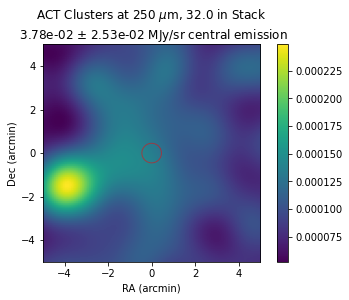

63.99999999998721 arcsec2
0.0014061381014993913 Jy / arcmin2


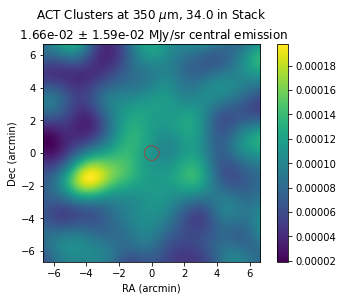

143.99999999997124 arcsec2
0.000604440755058059 Jy / arcmin2


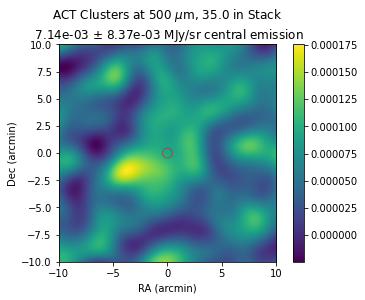

In [140]:
act_smooth_stacks = {'250':[], '350':[], '500':[]}

for freq in freqs:
        
    stack, cent, cent_var = filt_full_hersch_stacker(freq, ras_act, decs_act, 'ACT', width = 50., weight = False, smooth = True)
    act_smooth_stacks[freq].append(stack)
        

In [143]:
beams = np.linspace(0.4, 1, 20)

act_infered_t = []
act_infered_t_err = []

for beam in beams:
    MJys = []
    MJys_err = np.array([ 0.0253, 0.0159, 0.00837])*u.MJy/u.sr
    fit_freqs = np.array([250, 350, 500])*u.um
    
    for freq in freqs:

        hi_data = fits.open('/project/r/rbond/jorlo/herschel_maps/HATLAS/smoothed/HATLAS_SGP_DR2_FILT_BACKSUB{}_0.9SMOOTH.fits'.format(freq))


        w = wcs.WCS(hi_data[0].header)

        em = central_emission(act_smooth_stacks[freq][0], 50, wcs.utils.proj_plane_pixel_scales(w)[0]*60, beam/2)[0]*u.Jy
        em = em.to(u.MJy)
        area = (np.pi*(beam*u.arcmin)**2).to(u.sr)
        MJys.append((em/area).value)
        #print('Emission at {}: {}'.format(freq,em/area))
    MJys = np.array(MJys)*u.MJy/u.sr
    model = models.BlackBody(temperature = 100*u.K, scale = 1e-5 * u.MJy/u.sr)
    fitter = fitting.LevMarLSQFitter()

    best_fit = fitter(model, fit_freqs, MJys, weights=1.0/MJys_err**2)
    print(best_fit)
    act_infered_t.append(best_fit.temperature.value)
    cov_diag = np.diag(fitter.fit_info['param_cov'])
    act_infered_t_err.append(np.sqrt(cov_diag)[0].value)


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    7.470296030283695 1.3884585886701772e-06
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ----------------- ---------------------
    7.470689607864779 1.388295093851462e-06
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale        
            K                MJy / sr      
    ----------------- ---------------------
    6.928129407354526 1.603047118002794e-06
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       temperature            scale         
            K                MJy / sr       
    ----------------- ----------------------
    6.500507300500477

ValueError: Input must be 1- or 2-d.

In [180]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   62 / length of dimension 1                          
NAXIS2  =                 2839 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'name    '                                                            
TFORM1  = '14A     '                                                            
TDISP1  = 'A14     '                                                            
TTYPE2  = 'Photz   '                                                            
TFORM2  = 'D       '        